In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from numpy import asarray, savetxt
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from datetime import datetime, date
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import Tensor

In [2]:
batch_size = 64
validation_split = 0.90
epochs = 150
latent_dim = 100

In [3]:
class Discriminator(nn.Module):
    def __init__(self, c_dim=10, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 50),
            nn.Linear(50, 32*32*3),
        )
        self.main = nn.Sequential(
            nn.Conv2d(6, ndf, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 2, 3, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, image, label):
        label = self.label_layer(label)
        label = torch.reshape(label, (image.shape[0], 3, 32, 32))
        x = torch.cat([image, label], 1)
        return self.main(x)

In [4]:
class View(nn.Module):
    def forward(self, x):
        return x.view([x.shape[0], 256,4,4])

In [5]:
class Generator(nn.Module):
    def __init__(self, label_dim=2,latent_dim=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 50),
            nn.Linear(50, 7*7*3), 
        )
        self.latent_layer = nn.Sequential(
            nn.Linear(100, 128 * 7 * 7),
            nn.LeakyReLU(True),
        )
    
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6419, 256 * 4 * 4),
            View(),
            
            nn.ConvTranspose2d(256, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.Conv2d(ngf*2, nc, 3, 1, 'same', bias=False),
            nn.Tanh()
            
        )

    def forward(self, input_tensor: Tensor, label: Tensor):
        label = self.label_layer(label)
        label = torch.reshape(label, (input_tensor.shape[0], 3, 7, 7))
        
        latent_vector = self.latent_layer(input_tensor)
        latent_vector = torch.reshape(latent_vector, (input_tensor.shape[0], 128, 7, 7))
        x = torch.cat([latent_vector, label], 1)
        return self.main(x)

In [6]:
class DCGAN:
    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=32, device='cuda:0', lr_d=0.0002, lr_g=2e-4, label_smoothing_epsilon=0.1, labels_p_flip = 0.05, c_dim = 10):

        self.generator = Generator().to(device)
        self.discriminator = Discriminator().to(device)
        self.ls_epsilon = label_smoothing_epsilon
        self.p_flip = labels_p_flip
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.c_dim = c_dim

        self.d_losses = []
        self.g_losses = []

    def save_models(self):
        torch.save(self.generator.state_dict(), "./generator.pth")
        print("Saved PyTorch Model State to generator.pth")

        torch.save(self.discriminator.state_dict(), "./discriminator.pth")
        print("Saved PyTorch Model State to discriminator.pth")

    def generate_samples(self, latent_vec=None, num=None, labels=None):
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            gen_labels = labels if labels is not None else torch.randint(low=0, high=self.c_dim, size=(num,), device=self.device)
            samples = self.generator(latent_vec, gen_labels)
        samples = samples.cpu()
        return samples, gen_labels

    def train_step_generator(self, samples, labels):
        self.generator.zero_grad()
        
        fake_labels = torch.randint(low=0, high=self.c_dim, size=(samples.shape[0],), device=self.device)
        generated = self.generator(
            self.noise_fn(samples.size(0)),
            fake_labels
        )
        generated = 0.9*generated+0.1*torch.randn((generated.size()), device=self.device, dtype=torch.float)
        
        classifications = self.discriminator(generated, fake_labels)

        target_ones = self._get_ones(len(samples))
        loss = self.criterion(classifications, target_ones)
        
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self, real_samples, labels):
        self.discriminator.zero_grad()

        real_samples = 0.9*real_samples+0.1*torch.randn((real_samples.size()), device=self.device, dtype=torch.float)
        pred_real = self.discriminator(real_samples, labels)
        
        target_ones = self._get_ones(len(real_samples))
        loss_real = self.criterion(pred_real, target_ones)

        latent_vec = self.noise_fn(real_samples.size(0))
        gen_labels = torch.randint(low=0, high=self.c_dim, size=(real_samples.shape[0],), device=self.device)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec, gen_labels)
            fake_samples = 0.9 * fake_samples + 0.1 * torch.randn((fake_samples.size()), device=self.device, dtype=torch.float)
            
        pred_fake = self.discriminator(fake_samples, gen_labels)
        
        target_zeros = self._get_zeros(len(fake_samples))
        loss_fake = self.criterion(pred_fake, target_zeros)

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_epoch(self, print_frequency=10):
        loss_g_running, loss_d_real_running, loss_d_fake_running, batch = 0, 0, 0, 1
        for batch, (real_samples, labels) in enumerate(self.dataloader, start=1):
            real_samples, labels = real_samples.to(self.device), labels.to(self.device)

            ldr_, ldf_ = self.train_step_discriminator(real_samples, labels)
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
            self.d_losses.append((ldr_, ldf_))

            loss_g_running += self.train_step_generator(real_samples, labels)
            self.g_losses.append(loss_g_running)

            if (batch) % print_frequency == 0:
                print(f"{batch}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch ):.3f},"
                      f" Dr={loss_d_real_running / (batch):.3f},"
                      f" Df={loss_d_fake_running / (batch):.3f}",
                      end='\r',
                      flush=True)
        print('')
        print('--------')
        print('')

        return self.d_losses, self.g_losses

    def _flip_randomly_labels(self, y):
        number_of_labels_to_flip = int(self.p_flip * y.shape[0])
        labels_to_flip = np.random.choice([i for i in range(y.shape[0])], size=number_of_labels_to_flip)
        y[labels_to_flip] = 1 - y[labels_to_flip]
        return y
    
    def _get_ones(self, size):
        target_ones = torch.ones((size, 1), device=self.device,dtype=torch.float) - 0.3 + torch.randn((size, 1), device=self.device, dtype=torch.float) * 0.5
        target_ones = self._flip_randomly_labels(target_ones)
        return target_ones
    
    def _get_zeros(self, size):
        target_zeros = torch.zeros((size, 1), device=self.device,dtype=torch.float) + torch.randn((size, 1), device=self.device, dtype=torch.float) * 0.3
        target_zeros = self._flip_randomly_labels(target_zeros)
        return target_zeros

In [7]:
transform = A.Compose([
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

In [8]:
class Cifar10AugDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [9]:
m = Cifar10AugDataset(root='./data', train=True,
                                     download=True, transform=transform)

X_train, X_test, _, _ = train_test_split(
    range(len(m)),
    m.targets,
    stratify=m.targets,
    test_size=validation_split,
    random_state=8
)

train_split = Subset(m, X_train)
test_split = Subset(m, X_test)

train_data_loader = DataLoader(train_split, batch_size=batch_size,
                                                   shuffle=True)
test_data_loader = DataLoader(test_split, batch_size=batch_size,
                                                   shuffle=True)

Files already downloaded and verified


In [10]:
len(train_split)

5000

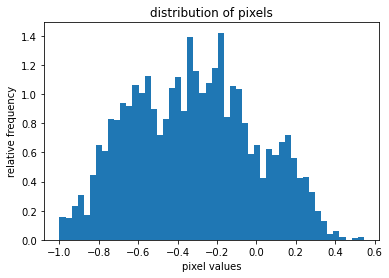

In [11]:
for x, y in test_data_loader:
    plt.hist(x[0].cpu().numpy().ravel(), bins=50, density=True)
    plt.xlabel("pixel values")
    plt.ylabel("relative frequency")
    plt.title("distribution of pixels")
    plt.show()
    break

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")
noise_fn = lambda batch_size: torch.randn(batch_size, latent_dim,device=device)

gan = DCGAN(latent_dim=latent_dim, noise_fn=noise_fn, batch_size=batch_size, device=device, dataloader=train_data_loader)
gan

Device used: cuda


In [13]:
start = datetime.combine(date.today(), datetime.now().time())
print(f'Starting time is: {start}')

for i in range(epochs):
    torch.backends.cudnn.benchmark = True
        
    current_time = datetime.combine(date.today(), datetime.now().time())
    print(f"Epoch {i + 1}; Elapsed time = {current_time - start}")
    d_loss, g_loss = gan.train_epoch(1)

end = datetime.combine(date.today(), datetime.now().time())
duration = end - start
print('')
print('')
print(f'Finished Training in: {duration}')
print('-----------')

gan.save_models()
savetxt('d-loss.csv', asarray(d_loss), delimiter=',')
savetxt('g-loss.csv', asarray(g_loss), delimiter=',')

Starting time is: 2022-03-24 11:19:49.482754
Epoch 1; Elapsed time = 0:00:00
79/79: G=1.230, Dr=0.883, Df=0.488
--------

Epoch 2; Elapsed time = 0:00:43.567975
79/79: G=0.966, Dr=0.877, Df=0.494
--------

Epoch 3; Elapsed time = 0:01:18.973112
79/79: G=0.969, Dr=0.874, Df=0.488
--------

Epoch 4; Elapsed time = 0:02:05.290489
79/79: G=0.941, Dr=0.882, Df=0.477
--------

Epoch 5; Elapsed time = 0:02:44.381687
79/79: G=0.905, Dr=0.859, Df=0.501
--------

Epoch 6; Elapsed time = 0:03:31.007436
79/79: G=0.891, Dr=0.859, Df=0.490
--------

Epoch 7; Elapsed time = 0:04:17.324154
79/79: G=0.877, Dr=0.856, Df=0.494
--------

Epoch 8; Elapsed time = 0:04:51.018763
79/79: G=0.888, Dr=0.848, Df=0.478
--------

Epoch 9; Elapsed time = 0:05:07.201433
79/79: G=0.895, Dr=0.861, Df=0.475
--------

Epoch 10; Elapsed time = 0:05:53.859782
79/79: G=0.862, Dr=0.862, Df=0.485
--------

Epoch 11; Elapsed time = 0:06:35.322249
79/79: G=0.860, Dr=0.843, Df=0.490
--------

Epoch 12; Elapsed time = 0:07:22.377

79/79: G=0.881, Dr=0.830, Df=0.472
--------

Epoch 98; Elapsed time = 1:11:53.460601
79/79: G=0.877, Dr=0.834, Df=0.472
--------

Epoch 99; Elapsed time = 1:12:37.830682
79/79: G=0.897, Dr=0.839, Df=0.470
--------

Epoch 100; Elapsed time = 1:13:22.187002
79/79: G=0.875, Dr=0.834, Df=0.464
--------

Epoch 101; Elapsed time = 1:14:06.549514
79/79: G=0.877, Dr=0.826, Df=0.481
--------

Epoch 102; Elapsed time = 1:14:50.918928
79/79: G=0.880, Dr=0.821, Df=0.488
--------

Epoch 103; Elapsed time = 1:15:35.290201
79/79: G=0.870, Dr=0.825, Df=0.485
--------

Epoch 104; Elapsed time = 1:16:19.689191
79/79: G=0.878, Dr=0.839, Df=0.467
--------

Epoch 105; Elapsed time = 1:17:04.072115
79/79: G=0.881, Dr=0.832, Df=0.466
--------

Epoch 106; Elapsed time = 1:17:48.471553
79/79: G=0.883, Dr=0.838, Df=0.461
--------

Epoch 107; Elapsed time = 1:18:32.843353
79/79: G=0.869, Dr=0.831, Df=0.474
--------

Epoch 108; Elapsed time = 1:19:17.209398
79/79: G=0.883, Dr=0.835, Df=0.468
--------

Epoch 109; 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


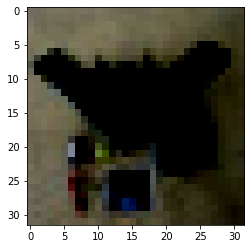

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


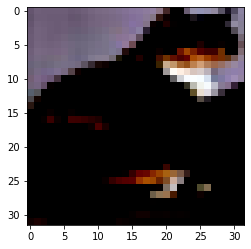

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


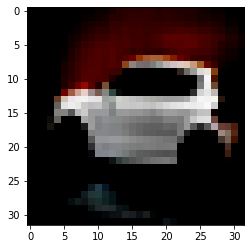

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


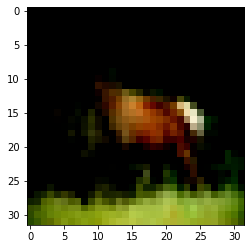

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


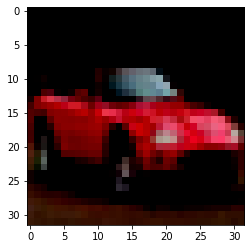

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


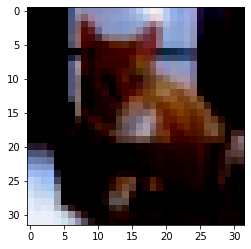

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


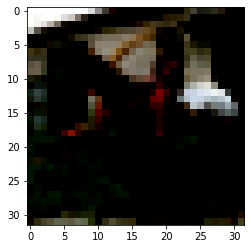

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


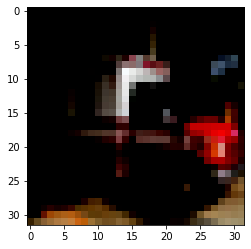

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


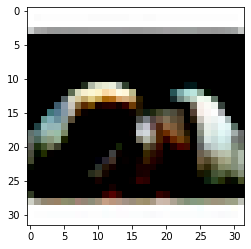

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


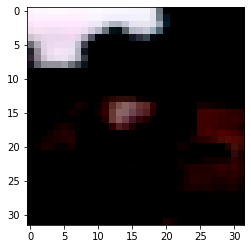

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


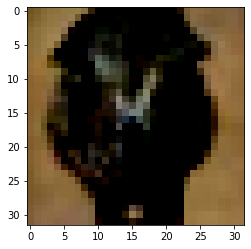

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


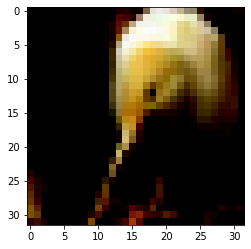

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


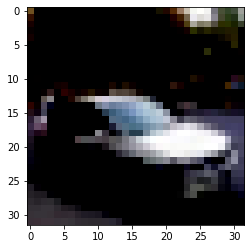

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


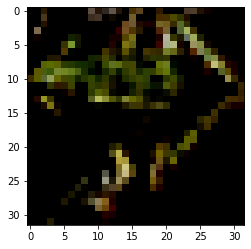

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


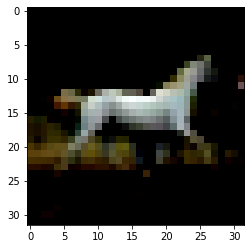

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


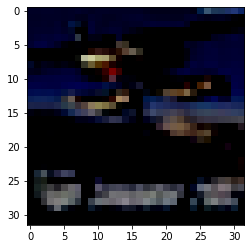

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


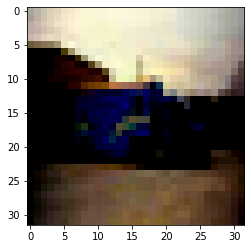

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


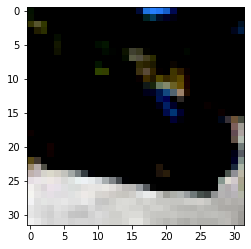

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


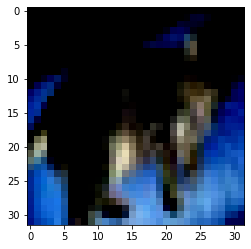

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


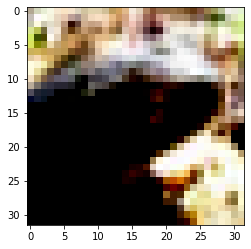

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


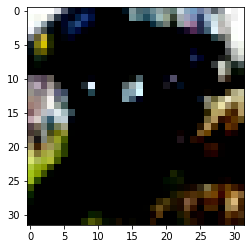

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


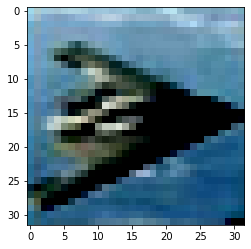

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


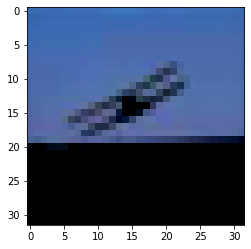

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


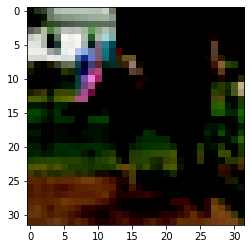

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


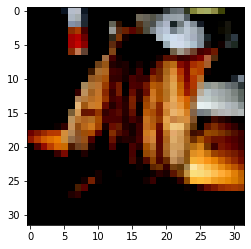

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


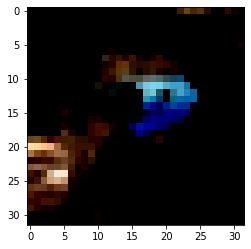

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


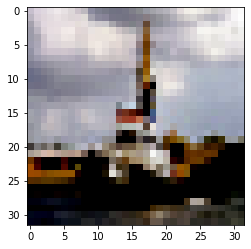

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


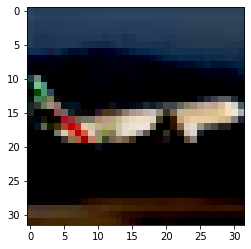

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


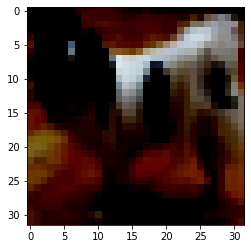

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


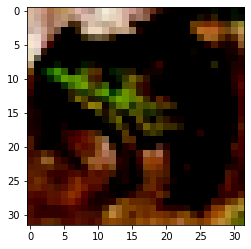

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


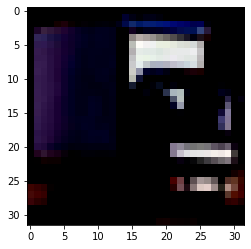

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


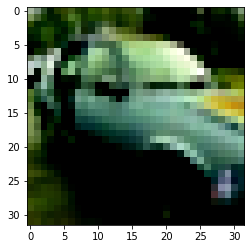

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


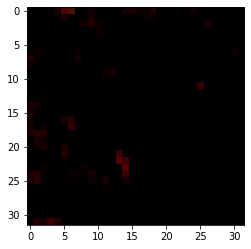

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


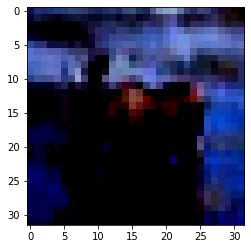

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


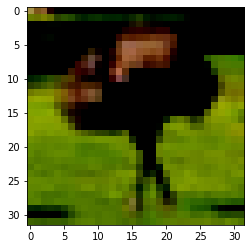

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


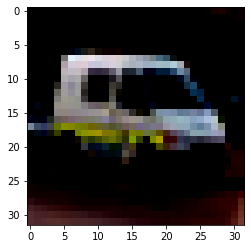

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


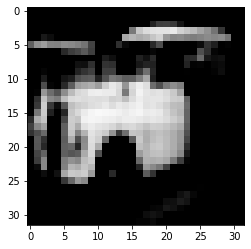

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


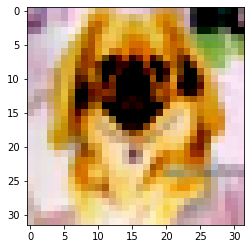

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


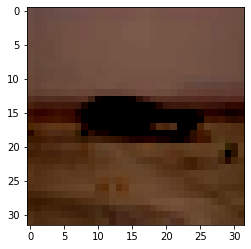

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


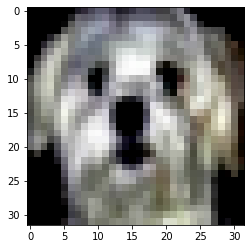

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


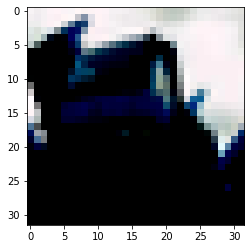

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


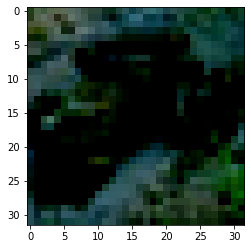

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


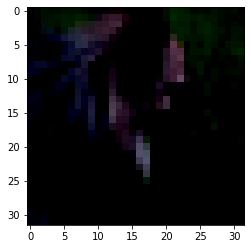

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


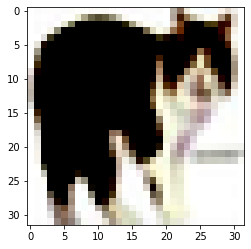

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


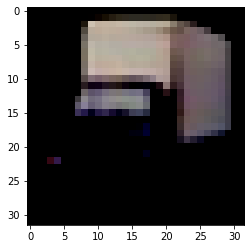

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


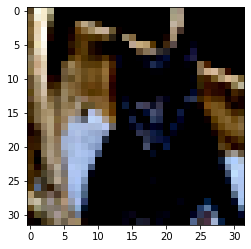

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


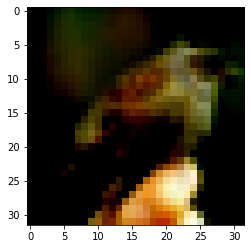

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


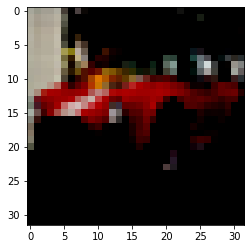

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


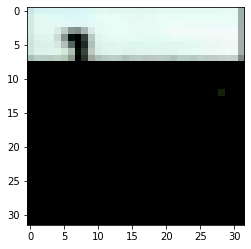

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


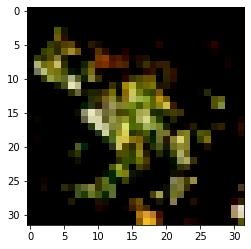

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


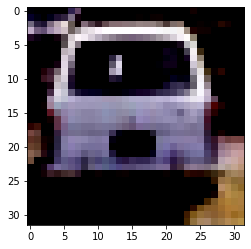

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


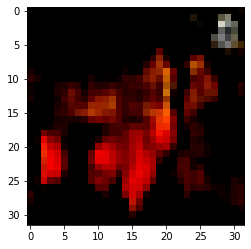

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


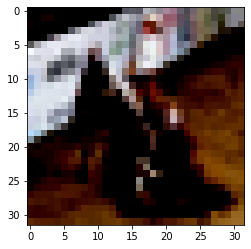

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


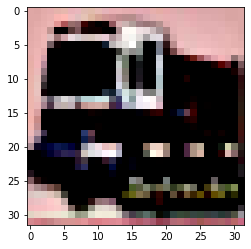

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


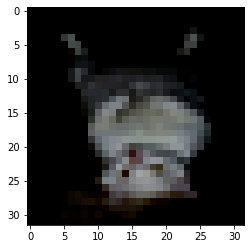

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


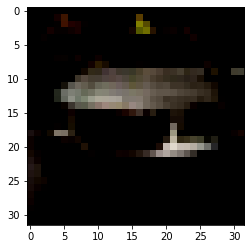

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


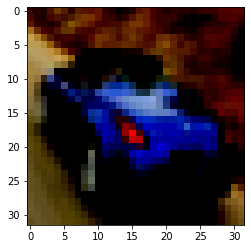

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


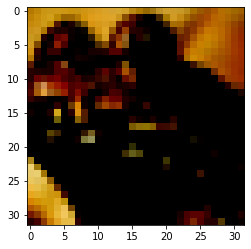

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


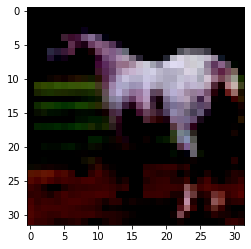

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


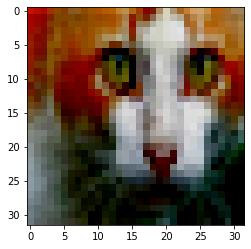

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


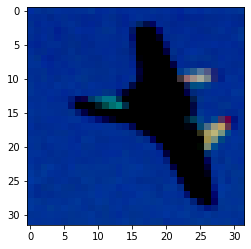

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


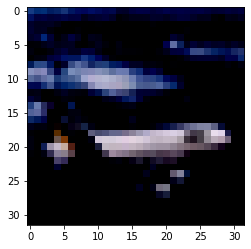

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


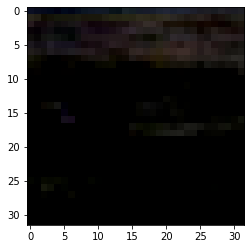

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


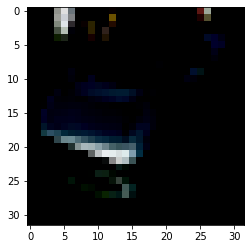

In [14]:
from matplotlib import pyplot
for images, _ in test_data_loader:
    for idx, img in enumerate(images):
        pyplot.imshow(img.numpy().transpose((1, 2, 0)))
        pyplot.show()
    break


In [17]:
classes = ('airplane', 'automobile', 'bird','car','deer','dog','frog','horse','ship','truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


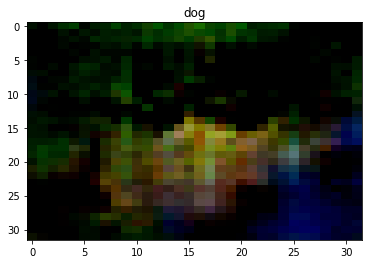

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


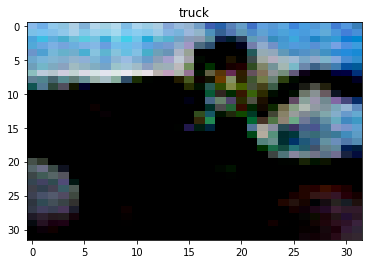

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


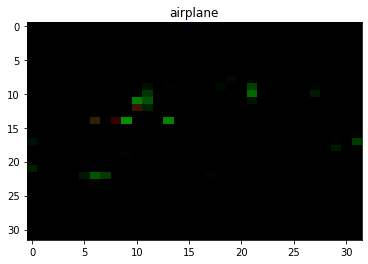

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


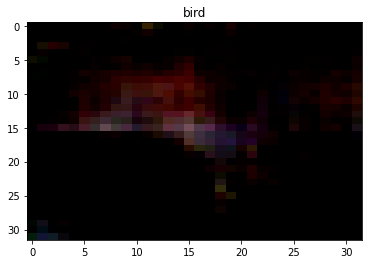

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


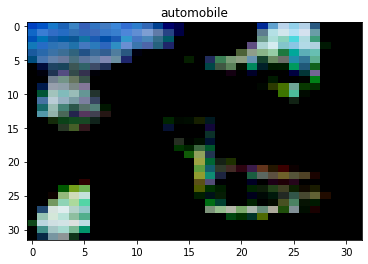

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


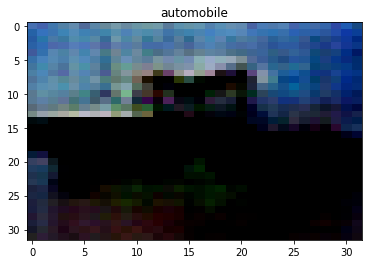

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


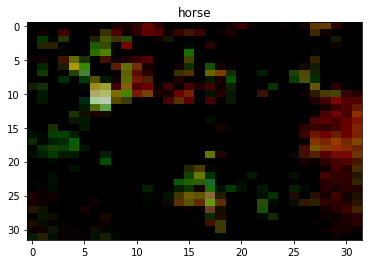

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


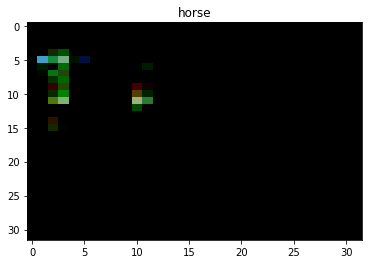

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


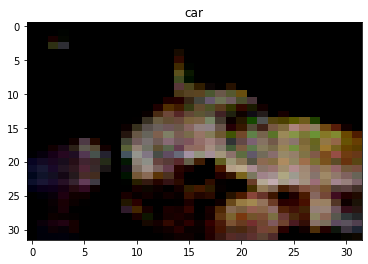

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


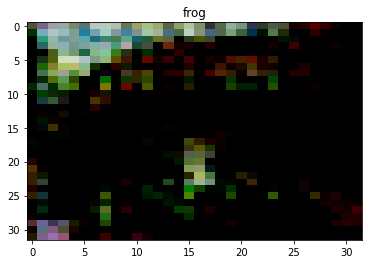

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


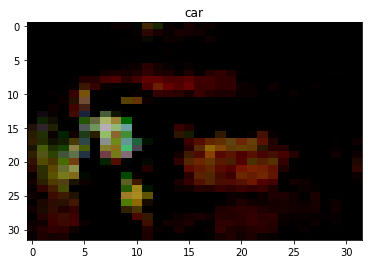

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


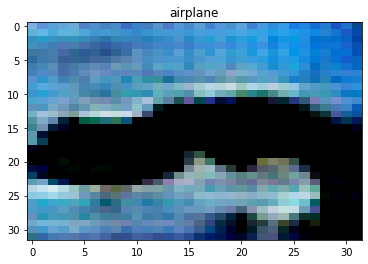

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


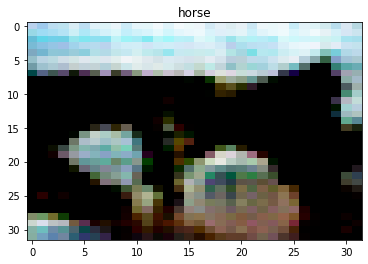

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


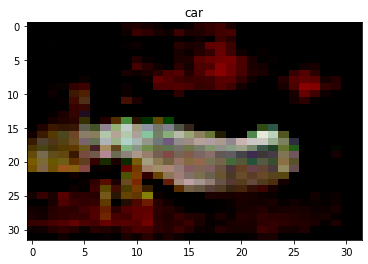

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


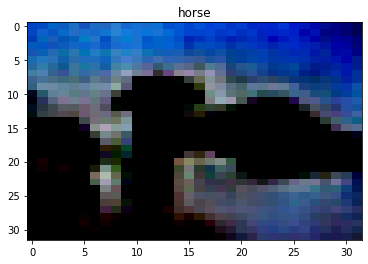

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


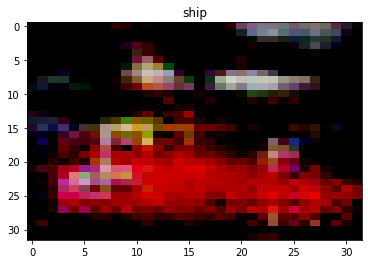

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


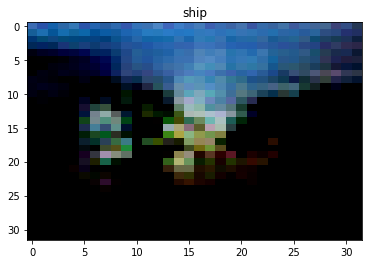

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


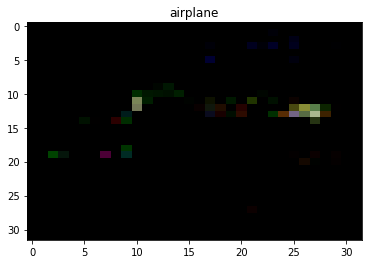

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


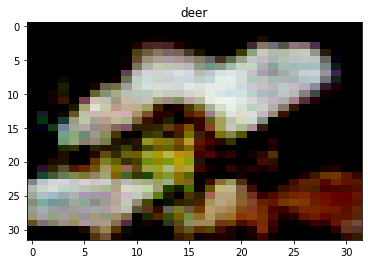

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


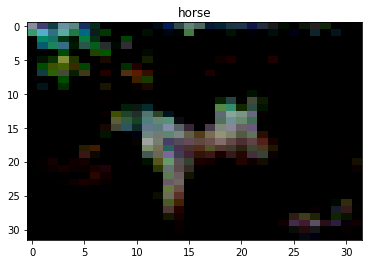

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


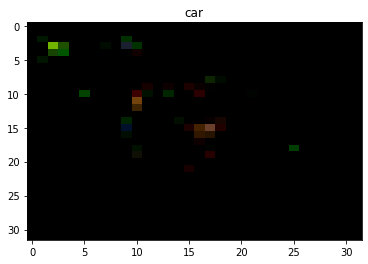

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


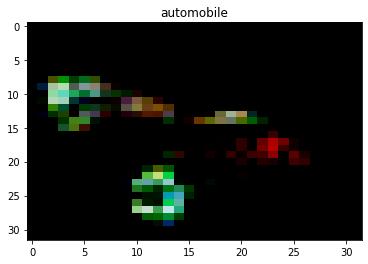

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


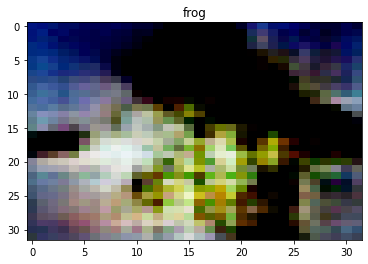

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


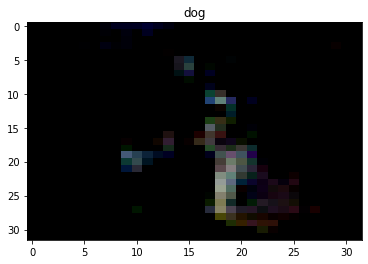

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


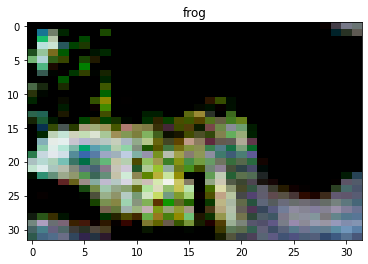

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


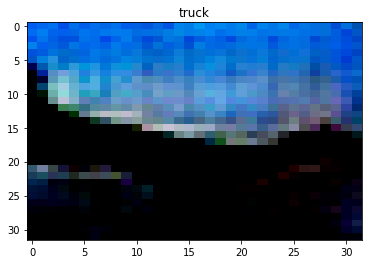

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


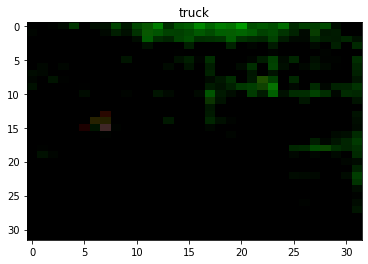

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


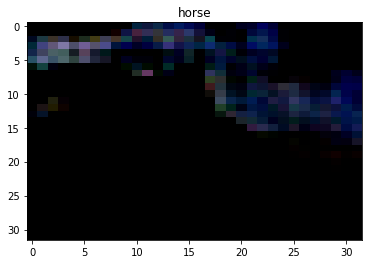

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


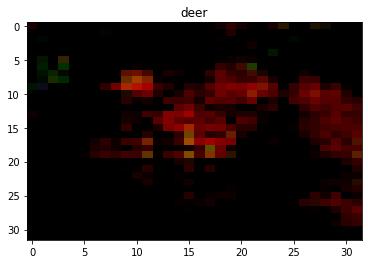

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


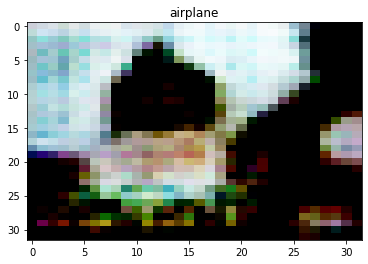

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


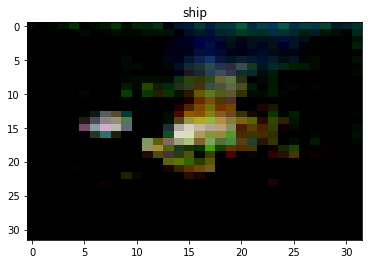

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


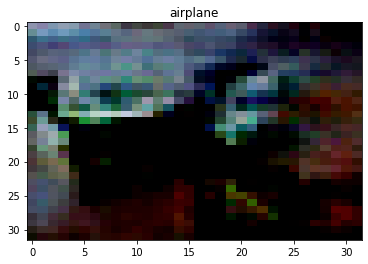

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


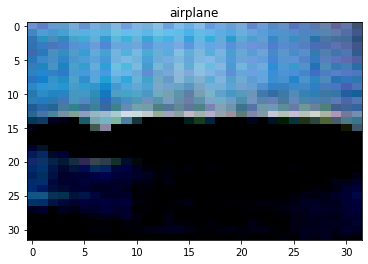

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


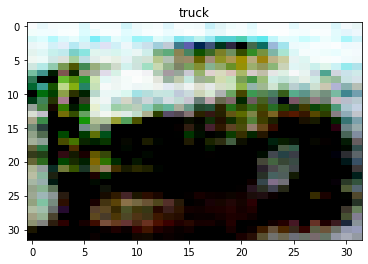

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


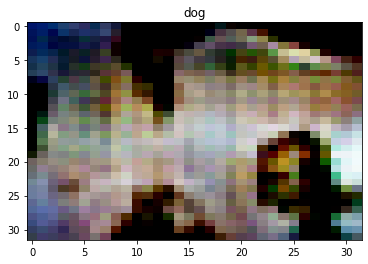

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


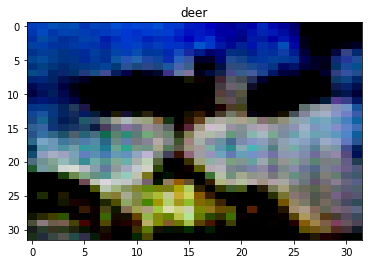

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


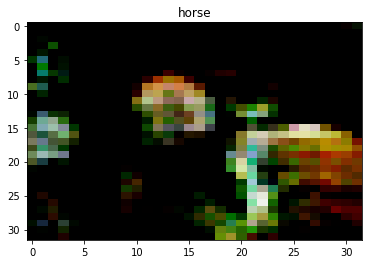

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


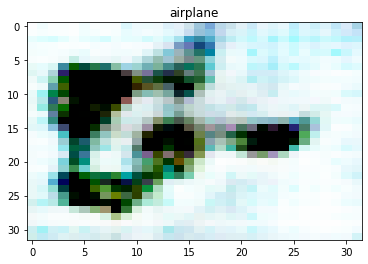

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


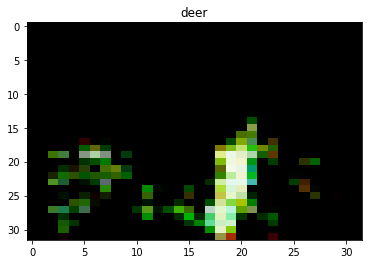

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


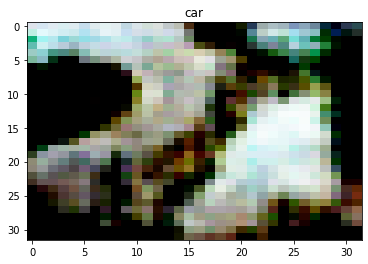

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


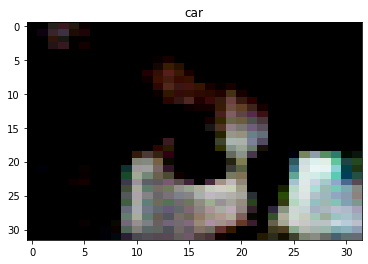

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


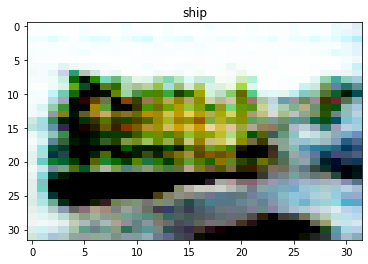

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


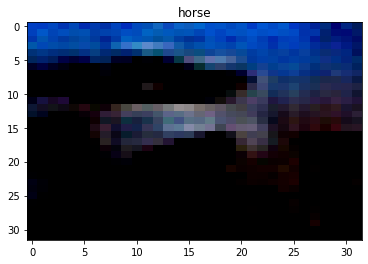

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


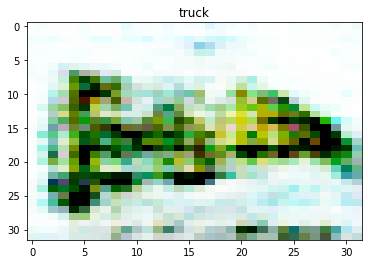

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


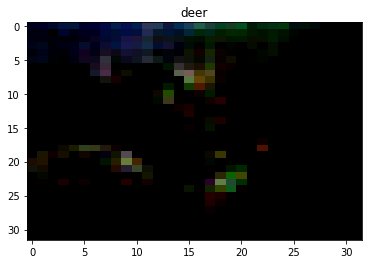

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


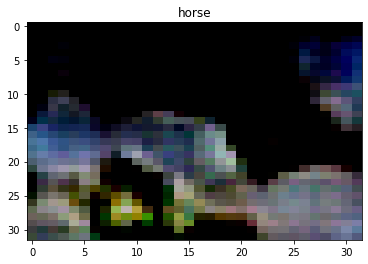

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


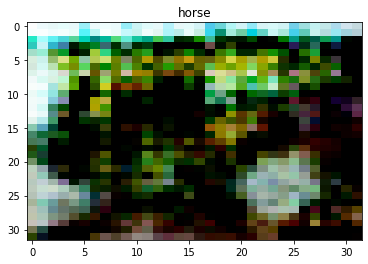

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


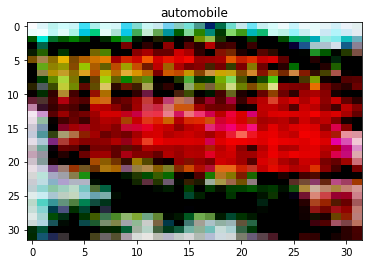

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


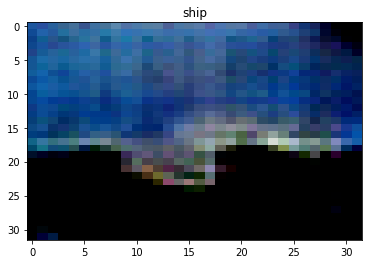

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


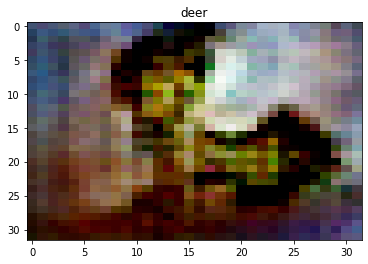

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


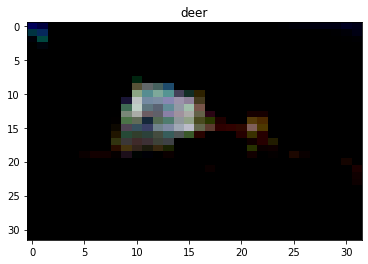

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


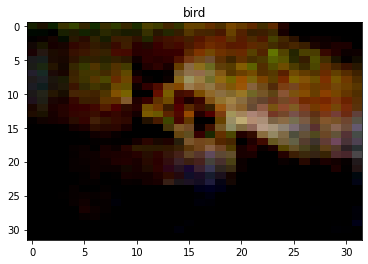

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


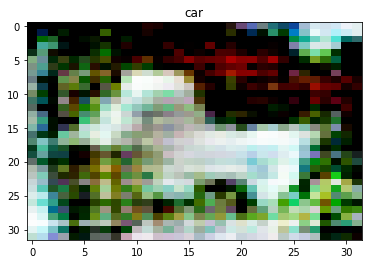

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


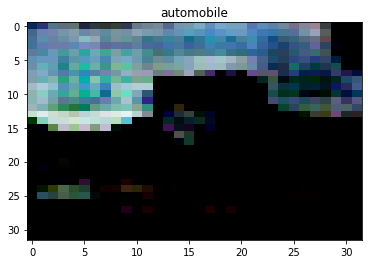

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


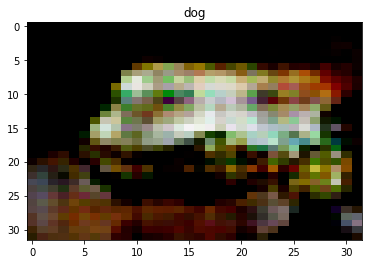

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


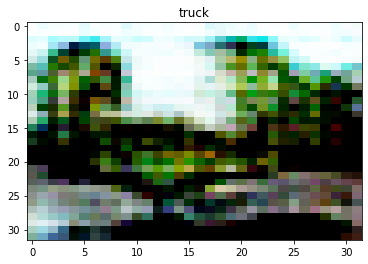

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


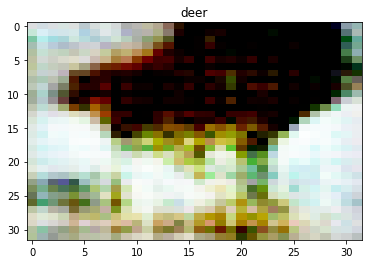

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


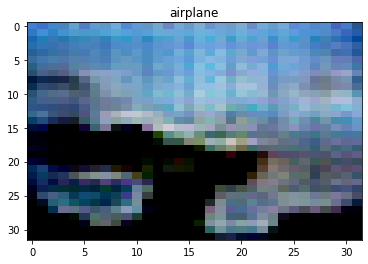

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


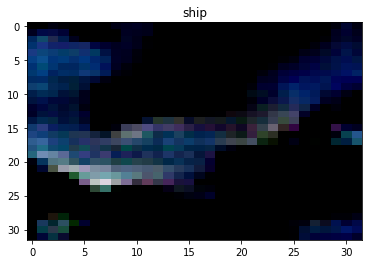

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


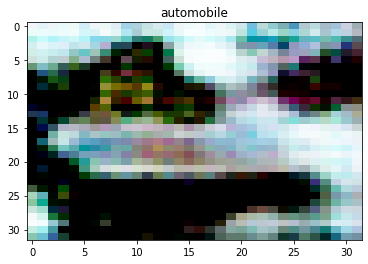

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


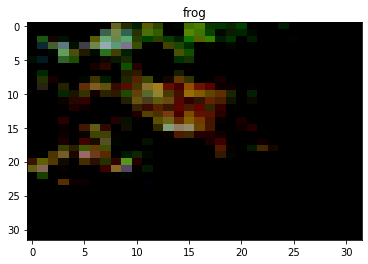

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


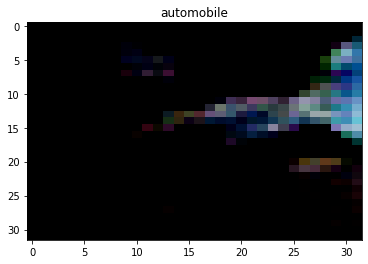

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


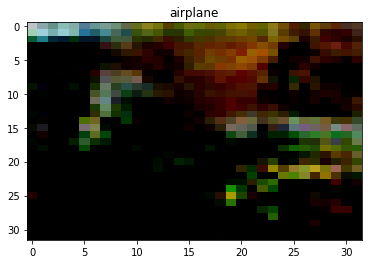

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


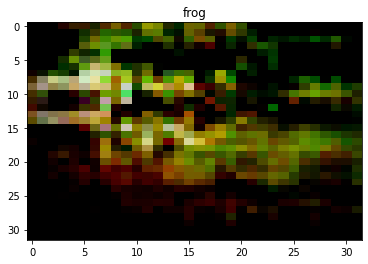

In [19]:
images, labels = gan.generate_samples()
for img, label in zip(images, labels):
    pyplot.imshow(img.numpy().transpose((1, 2, 0)), aspect='auto')
    pyplot.title(classes[label.cpu().numpy()])
    pyplot.show()